In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 4.53 μs


In [3]:
# configuration settings
bias_range = 0
dummy_targets = False
data_root = f'../data/phantom_lung3_{bias_range}_{dummy_targets:d}'
mesh_version = 10
test_pid = 0

input_anat = False
input_coords = True

model_arch = 'unet3d'
num_levels = 3
num_conv_layers = 1
conv_channels = 8
conv_kernel_size = 3
output_func = 'softplus'

trainer_task = 'fit'
rho_value = 0
interp_size = 5
interp_type = 'tent'
batch_size = 1
learning_rate = 1e-5
num_epochs = 2000
test_every = 100
save_every = 100
save_prefix = '2024-12-12__coords/asdf'

#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'

In [4]:
project.utils.set_random_seed(None)

Setting random seed to 2460671495


Loading ../data/phantom_lung3_0_0/phantom0/phantom0_anat.nii.gz
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_elast.nii.gz
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_disp.nii.gz
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_mask.nii.gz


<IPython.core.display.Javascript object>


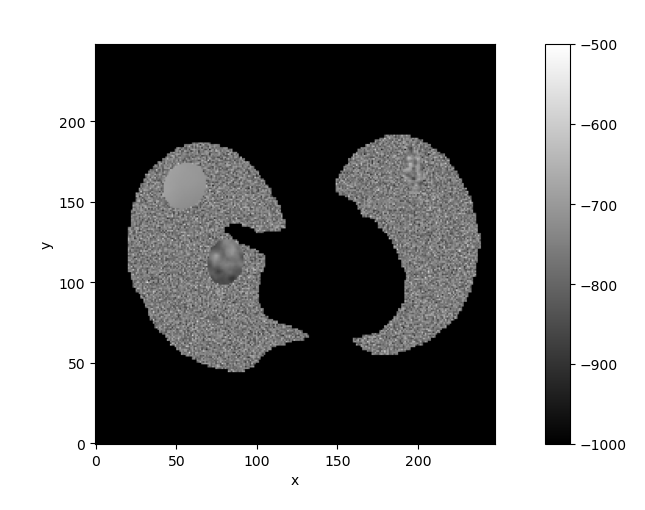

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

<IPython.core.display.Javascript object>


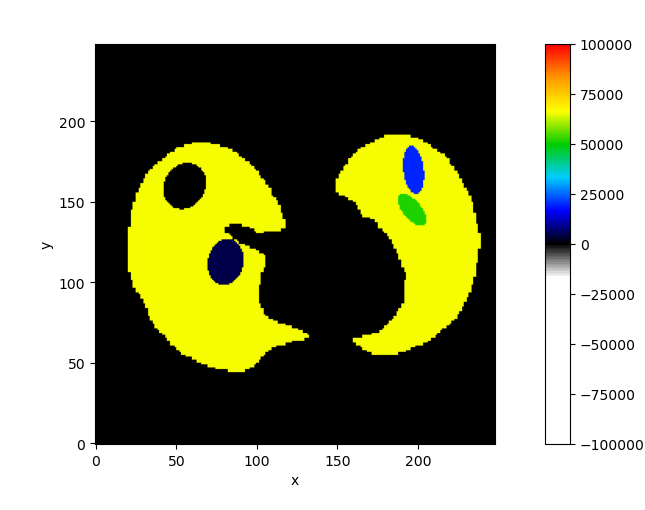

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

<IPython.core.display.Javascript object>


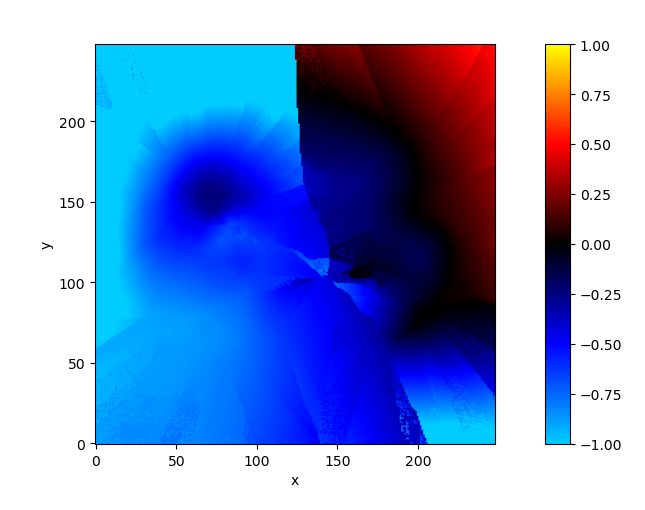

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

Loading ../data/phantom_lung3_0_0/phantom0/phantom0_mesh10.xdmf
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_mesh10.xdmf... 5064


In [5]:
%autoreload
phantom_set = project.phantom.PhantomSet(data_root, phantom_ids=range(100))

phantom = phantom_set[0]
phantom.load_niftis()

z_slice = int(100 // 2.5)
project.visual.XArrayViewer(phantom.anat).update_index(z=z_slice)
project.visual.XArrayViewer(phantom.elast).update_index(z=z_slice)
project.visual.XArrayViewer(phantom.disp).update_index(z=z_slice, component=0)

phantom.load_mesh(mesh_version)
phantom.mesh

```






```

In [6]:
all_examples = phantom_set.get_examples(mesh_version)

if test_pid is None:
    train_examples = all_examples[10:]
    test_examples = all_examples[:10]
else:
    train_examples = all_examples
    test_examples = [train_examples.pop(test_pid)]

len(train_examples), len(test_examples)

(99, 1)

In [7]:
test_examples[0]

{'name': 'phantom0',
 'anat_file': PosixPath('../data/phantom_lung3_0_0/phantom0/phantom0_anat.nii.gz'),
 'elast_file': PosixPath('../data/phantom_lung3_0_0/phantom0/phantom0_elast.nii.gz'),
 'disp_file': PosixPath('../data/phantom_lung3_0_0/phantom0/phantom0_disp.nii.gz'),
 'mask_file': PosixPath('../data/phantom_lung3_0_0/phantom0/phantom0_mask.nii.gz'),
 'mesh_file': PosixPath('../data/phantom_lung3_0_0/phantom0/phantom0_mesh10.xdmf'),
 'has_labels': False}

In [8]:
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [ ]:
%autoreload

if model_arch == 'unet3d':
    model = project.model.UNet3D(
        in_channels=1*input_anat + 3*input_coords,
        out_channels=1,
        num_levels=num_levels,
        num_conv_layers=num_conv_layers,
        conv_channels=conv_channels,
        conv_kernel_size=conv_kernel_size,
        output_func=output_func
    ).cuda()
    
elif model_arch == 'param_map':
    shape = test_data[0][1].shape
    model  = project.model.ParameterMap(
        shape=(1, shape[1]//2, shape[2]//2, shape[3]//2),
        upsample_mode='nearest',
        conv_kernel_size=3,
        output_func=output_func
    ).cuda()
    
model

In [ ]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    test_every=test_every,
    save_every=save_every,
    save_prefix=save_prefix,
    input_anat=input_anat,
    input_coords=input_coords
)

In [ ]:
load_epoch = 0
if load_epoch:
    trainer.load_state(epoch=load_epoch)

In [ ]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=trainer.epoch)

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
trainer.optimizer.param_groups[0]['lr'] = 1e-5

In [ ]:
%autoreload
trainer.timer.start()
if trainer_task == 'train':
    trainer.train(num_epochs)
elif trainer_task == 'fit':
    trainer.fit(num_epochs)

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='mean', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
anat_image, E_true_image, u_image, mask, resolution, pde, example_name = test_data[6]
anat_image.shape

In [ ]:
E_pred_image = model.forward(anat_image.unsqueeze(0).cuda())[0].cpu() * 1000
mask.shape, mask.max()

In [ ]:
E_pred_image.mean()

In [ ]:
%autoreload
import torch

# compute contrast relative to background
eps = 1e-6
C_true_image = torch.log10(E_true_image / E_true_image[mask == 1].median() + eps)
C_pred_image = torch.log10(E_pred_image / E_pred_image[mask == 1].median() + eps)
CTE_image = 10**-(C_pred_image - C_true_image).abs()

z = 45
project.visual.XArrayViewer(
    project.utils.as_xarray( (C_true_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_true'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (C_pred_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_pred'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (CTE_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='CTE'),
).update_index(c=0, z=z)

print(CTE_image[mask > 1].median().item())

In [ ]:
os.listdir('/ocean/projects/asc170022p/shared/Data/4DLungCT')